In [9]:
# importing libraries
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
column_rename_dict = {
    "PM 2,5": "PM2.5",
    "Partículas Respiráveis (<2,5µm)(µg/m3)": "PM2.5",
    "Partículas Inaláveis (<10µm)(µg/m3)": "PM10",
    "Temperatura (ºC)": "Temperatura",
    "Tº": "Temperatura",
    "Radiação Solar (W/m2)": "Radiação Solar",
    "Monóxido de Carbono (ppm)": "Monóxido de Carbono",
    "CO": "Monóxido de Carbono",
    "Velocidade Escalar do Vento (m/s)": "Velocidade do Vento",
    "Direção Escalar do Vento (grau)": "Direção do Vento",
    "Umidade relativa (%)": "Umidade Relativa",
    "Precipitação Pluviométrica (mm)": "Precipitação",
    "Pressão Atmosférica (mmHg)": "Pressão Atmosférica",
    "Dióxido de enxofre (ppb)": "Dióxido de Enxofre",
    "Ozônio (ppb)": "Ozônio",
    "Monóxido de Nitrogênio (ppb)": "Monóxido de Nitrogênio",
    "Óxidos de Nitrogênio (ppb)": "Óxidos de Nitrogênio",
    "Dióxido de Nitrogênio (ppb)": "Dióxido de Nitrogênio",
    "HCT (ppm)": "HCT",
    "CH4 (ppm)": "Metano",
    "HCNM (ppm)": "HCNM",
    "Monóxido de Carbono Média Móvel (ppm)": "Monóxido de Carbono Média Móvel",
    "Data": "Data",
    "Hora": "Hora",
    "Média Horária": "Média Horária",
    "Seno da direção do vento": "Seno da Direção do Vento",
    "Cosseno da direção do vento": "Cosseno da Direção do Vento",
    "Seno ponderado": "Seno Ponderado",
    "Cosseno ponderado": "Cosseno Ponderado",
    "PM10": "PM10",
    "NO2": "Dióxido de Nitrogênio",
    "O3": "Ozônio",
    "SO2": "Dióxido de Enxofre",
    "DV": "Direção do Vento",
    "PP": "Pressão Atmosférica",
    "PA": "Precipitação",
    "VV": "Velocidade do Vento",
    "RS": "Radiação Solar",
    "UR": "Umidade Relativa"
}

In [11]:
import os
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor

pd.set_option('future.no_silent_downcasting', True)
main_folder = "data"
station_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

def get_skiprows(year, station):
    if year == 2021 and station == "Cascata":
        return [0, 1, 3]
    elif year >= 2015:
        return [0, 2]
    else:
        return None

def process_station(station_folder):
    base_path = os.path.join(main_folder, station_folder)
    files = [f for f in os.listdir(base_path) if f.endswith(".xlsx")]
    
    for file in reversed(files):
        year = int(file.split("_")[1].split(".")[0])
        file_path = os.path.join(base_path, file)
        skiprows = get_skiprows(year, station_folder)
        df = pd.read_excel(file_path, skiprows=skiprows)
            
        if year < 2015:
            df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y', errors='coerce')
            df['Hora'] = pd.to_datetime(df['Hora'], format='%H:%M:%S', errors='coerce').dt.time
            df['Data e Hora'] = pd.to_datetime(df['Data'].astype(str) + ' ' + df['Hora'].astype(str), errors='coerce')
            df = df.drop(columns=['Data', 'Hora'])
        else:
            df.rename(columns={df.columns[0]: 'Data e Hora'}, inplace=True)
            df['Data e Hora'] = pd.to_datetime(df['Data e Hora'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
        
        df = df[df['Data e Hora'].notna()]
        df.set_index('Data e Hora', inplace=True)
        
        valid_columns = df.columns.intersection(column_rename_dict.keys())
        df.rename(columns={col: column_rename_dict[col] for col in valid_columns}, inplace=True)
        
        df = df.dropna(axis=1, how='all')
        df.replace('*', np.nan, inplace=True)
        pm25_missing = df['PM2.5'].isna().sum()        
        pm25_total = len(df)
        percentual = pm25_missing/pm25_total
        print(f"Estação: {station_folder}, Ano: {year}, Dados ausentes de PM2.5: {pm25_missing}/{pm25_total} ({percentual:.2%})")
        
        treated_folder = os.path.join("tratados", station_folder)
        os.makedirs(treated_folder, exist_ok=True)
        os.makedirs(os.path.join(treated_folder, "csv"), exist_ok=True)
        os.makedirs(os.path.join(treated_folder, "excel"), exist_ok=True)
        treated_file_path_csv = os.path.join(treated_folder,"csv", f"{station_folder}_{year}_treated.csv")
        treated_file_path_xlsx = os.path.join(treated_folder,"excel", f"{station_folder}_{year}_treated.xlsx")
        df.to_csv(treated_file_path_csv)
        df.to_excel(treated_file_path_xlsx)

    # Combinar os dados tratados de todos os anos para cada estação
    treated_folder = os.path.join("tratados",station_folder, "csv")
    treated_files = [f for f in os.listdir(treated_folder) if f.endswith(".csv")]
    treated_dfs = []
    for treated_file in treated_files:
        treated_file_path = os.path.join(treated_folder, treated_file)
        treated_df = pd.read_csv(treated_file_path, index_col='Data e Hora', parse_dates=True, low_memory=False)
        treated_dfs.append(treated_df)
    combined_treated_data = pd.concat(treated_dfs, ignore_index=False, axis=0)
    combined_treated_data.dropna(subset='PM2.5', inplace=True)
    combined_treated_data.replace('*', np.nan, inplace=True)
    combined_treated_data.reset_index(inplace=True)
    combined_treated_data.rename(columns={'index': 'Data e Hora'}, inplace=True)
    combined_treated_data.to_csv(f"tratados/{station_folder}/csv/{station_folder}_combined_treated.csv", index=False)
    combined_treated_data.to_excel(f"tratados/{station_folder}/excel/{station_folder}_combined_treated.xlsx", index=False)

# Paralelizando o processamento de cada estação
with ThreadPoolExecutor() as executor:
    executor.map(process_station, station_folders)


Estação: Cascata, Ano: 2022, Dados ausentes de PM2.5: 3961/8760 (45.22%)
Estação: Piratininga, Ano: 2022, Dados ausentes de PM2.5: 446/8760 (5.09%)
Estação: Cascata, Ano: 2021, Dados ausentes de PM2.5: 1539/8760 (17.57%)
Estação: Piratininga, Ano: 2021, Dados ausentes de PM2.5: 564/8760 (6.44%)
Estação: Cascata, Ano: 2020, Dados ausentes de PM2.5: 1147/8784 (13.06%)
Estação: Piratininga, Ano: 2020, Dados ausentes de PM2.5: 989/8784 (11.26%)
Estação: Cascata, Ano: 2019, Dados ausentes de PM2.5: 918/8760 (10.48%)
Estação: Piratininga, Ano: 2019, Dados ausentes de PM2.5: 1316/8760 (15.02%)
Estação: Cascata, Ano: 2018, Dados ausentes de PM2.5: 1649/8760 (18.82%)
Estação: Piratininga, Ano: 2018, Dados ausentes de PM2.5: 1299/8760 (14.83%)
Estação: Cascata, Ano: 2017, Dados ausentes de PM2.5: 1462/8760 (16.69%)
Estação: Piratininga, Ano: 2017, Dados ausentes de PM2.5: 1313/8760 (14.99%)
Estação: Cascata, Ano: 2016, Dados ausentes de PM2.5: 2157/8784 (24.56%)
Estação: Piratininga, Ano: 2016, 

In [12]:
# 'describe' dos dados tratados

station_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]
for station_folder in reversed(station_folders):
    df_treated = pd.read_excel(f"tratados/{station_folder}/excel/{station_folder}_combined_treated.xlsx")
    print(f"Estação: {station_folder}")
    print(df_treated['PM2.5'].describe())
    print("-" * 50)

Estação: Piratininga
                         Data e Hora  Velocidade do Vento  Direção do Vento  \
count                         534406        512097.000000     519845.000000   
mean   2019-06-02 07:04:55.514646016             1.493228        127.001690   
min              2015-11-04 10:30:00             0.030000          0.000000   
25%              2017-08-24 15:30:00             0.820000         70.330000   
50%              2019-06-03 16:30:00             1.340000         90.820000   
75%              2021-03-20 09:30:00             2.040000        162.600000   
max              2022-12-31 23:30:00             6.500000        360.000000   
std                              NaN             0.878628         82.861372   

         Temperatura  Umidade Relativa  Precipitação  Pressão Atmosférica  \
count  521855.000000     522263.000000           0.0        522982.000000   
mean       22.450867         64.750139           NaN             0.147647   
min         6.490000         10.6400

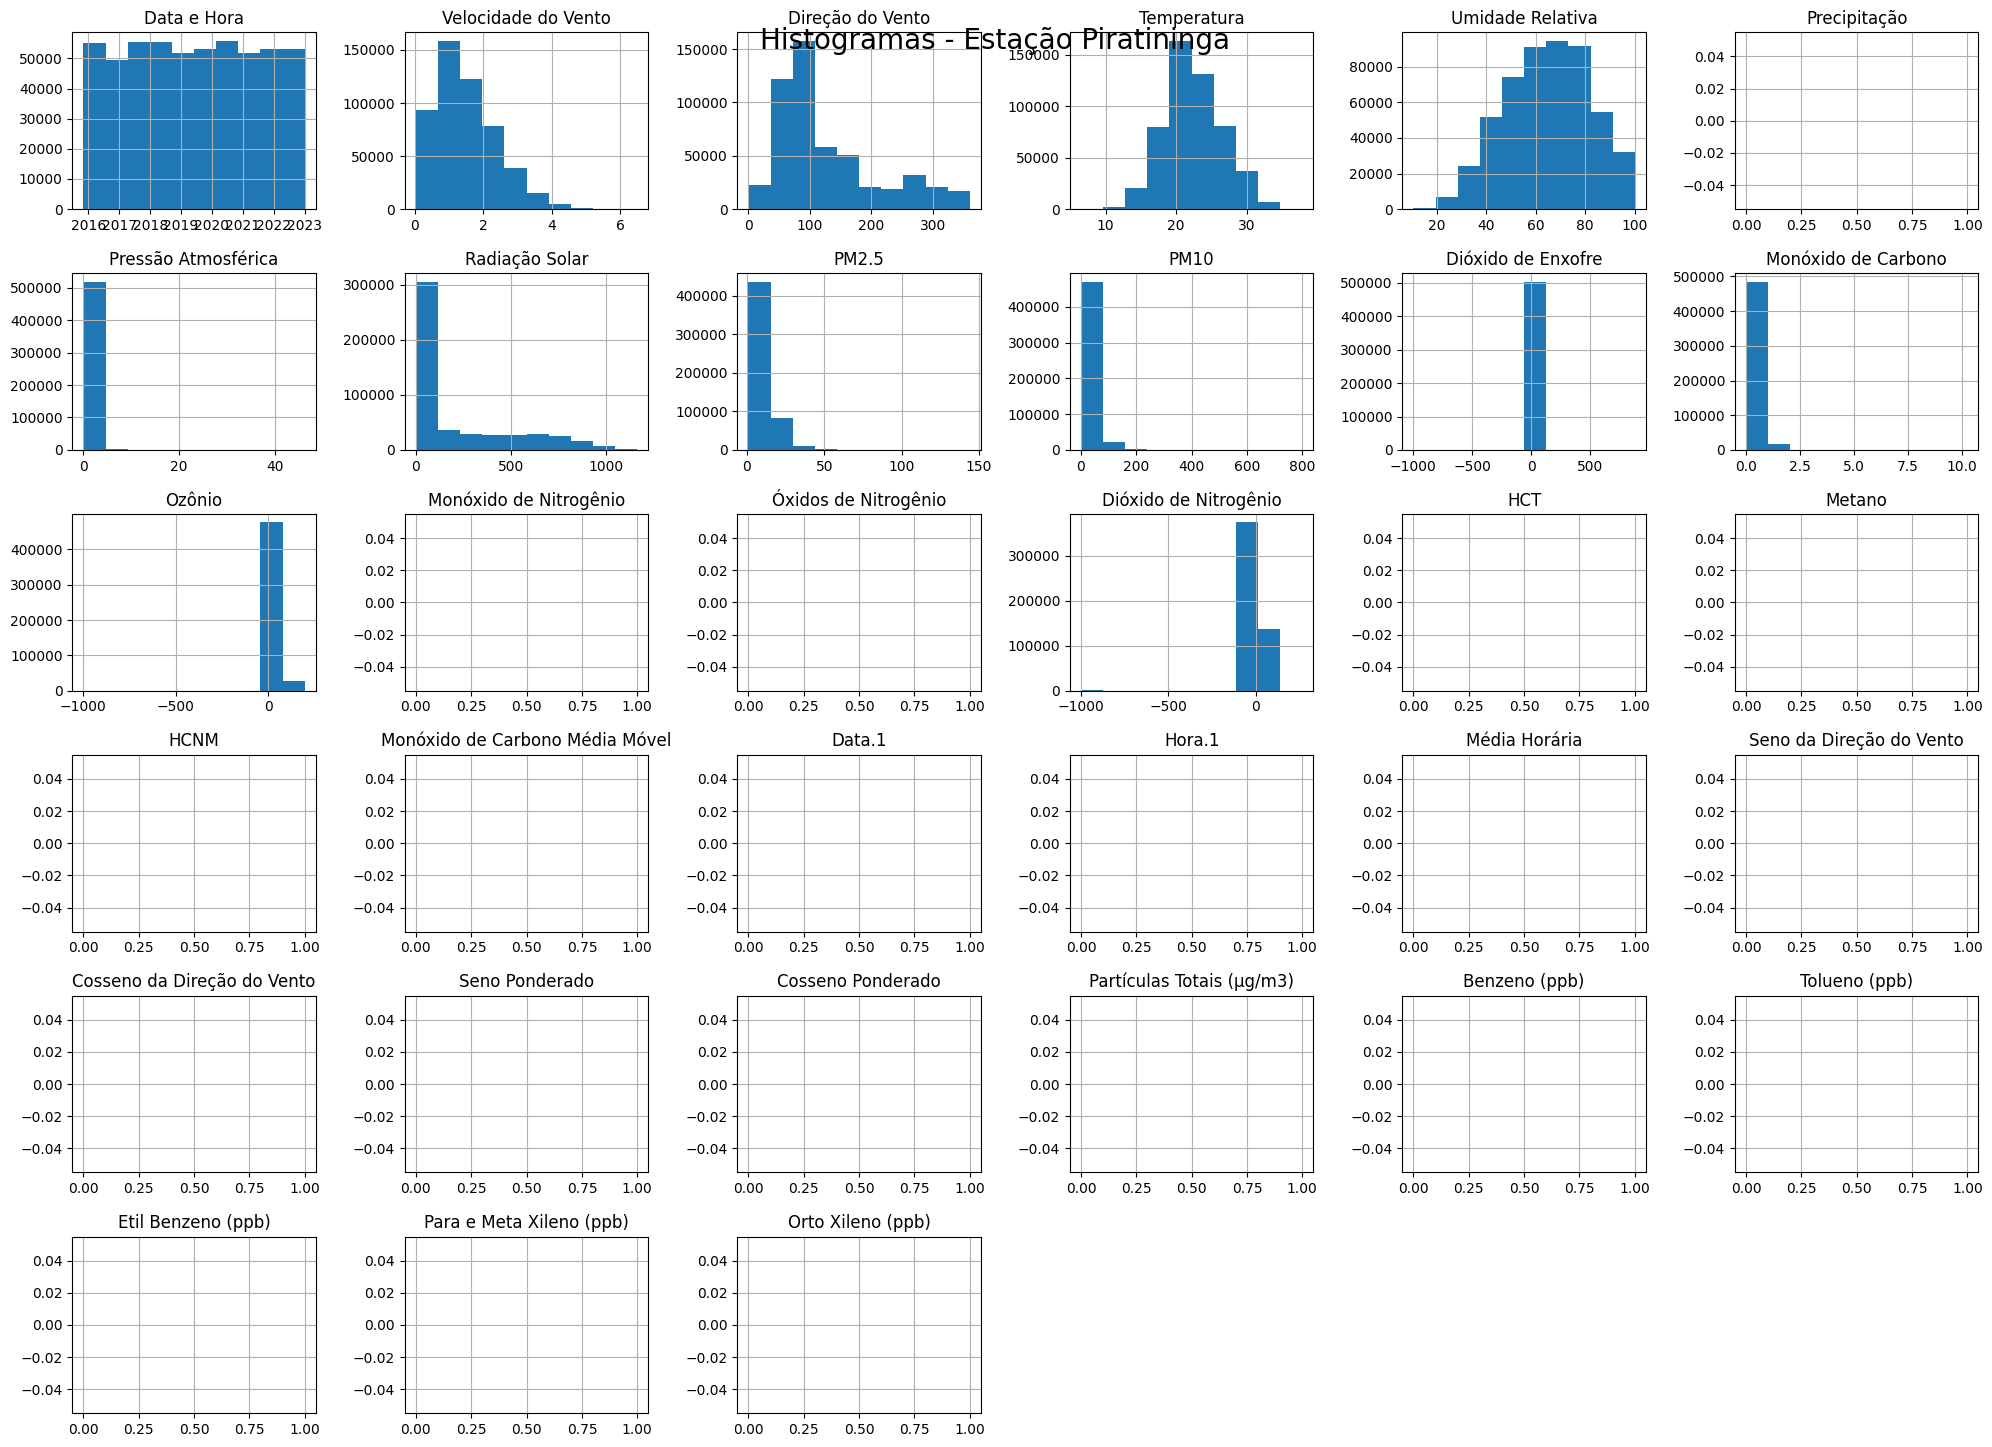

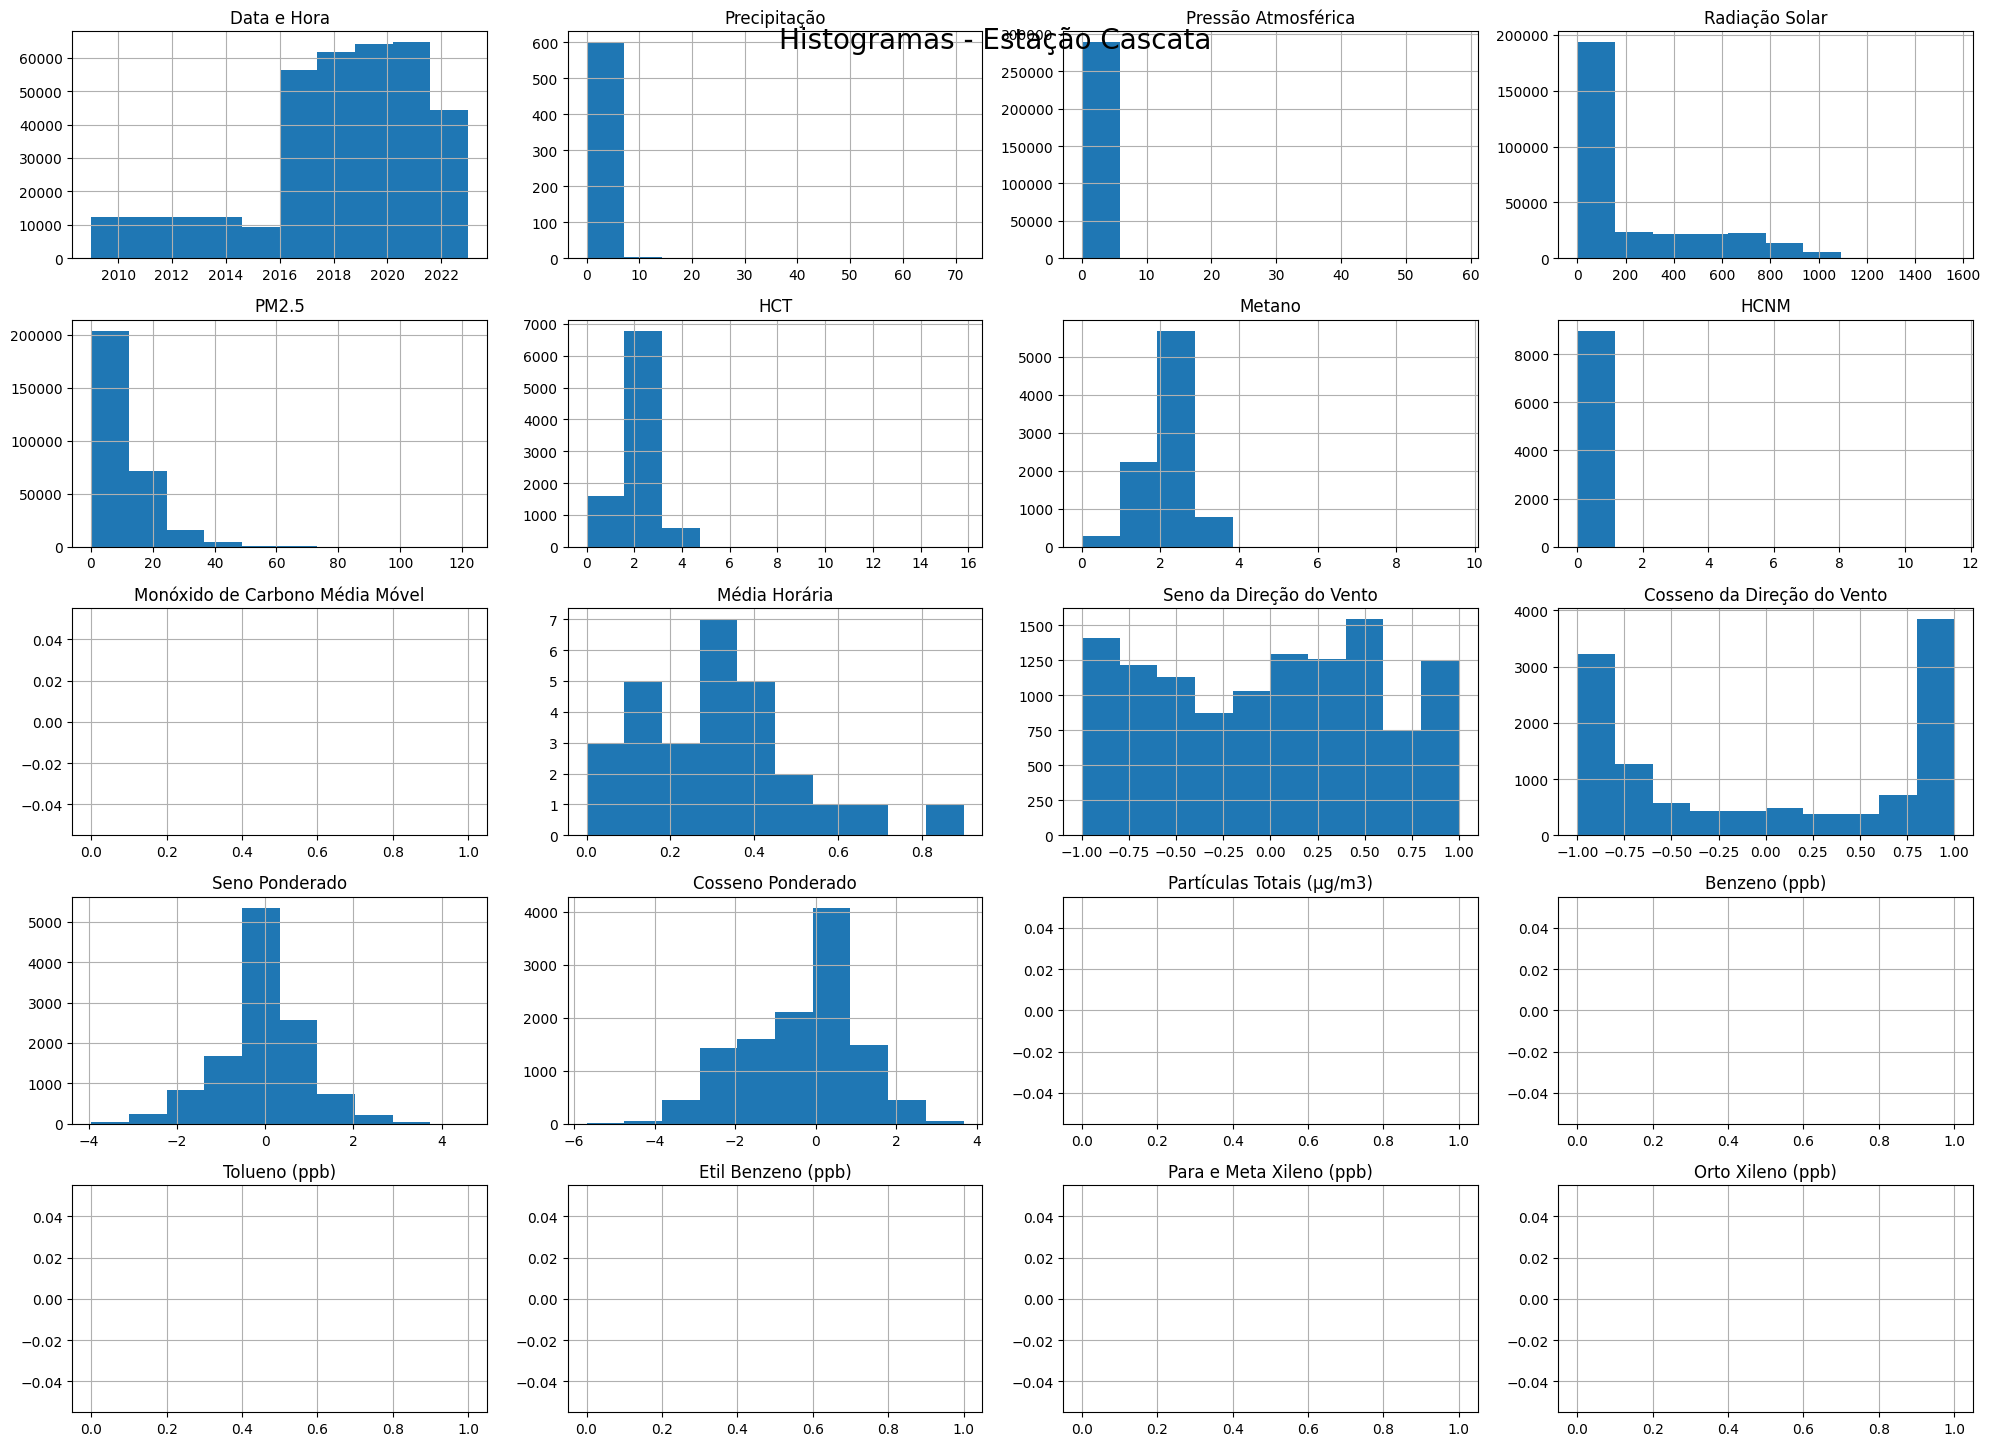

In [13]:
import matplotlib.pyplot as plt

# plotando histogramas
station_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]
for station_folder in reversed(station_folders):
    df_treated = pd.read_excel(f"tratados/{station_folder}/excel/{station_folder}_combined_treated.xlsx")
    df_treated.hist(figsize=(20, 15))
    plt.suptitle(f"Histogramas - Estação {station_folder}", y=0.95, fontsize=20)
    plt.tight_layout()
    plt.show()
    

Estação: Piratininga
Quantidade de outliers: 22874
               Data e Hora  Velocidade do Vento  Direção do Vento  \
23     2015-11-05 10:30:00                 1.30            310.24   
24     2015-11-05 11:30:00                 1.14            343.25   
30     2015-11-05 17:30:00                 0.69            255.61   
31     2015-11-05 18:30:00                 0.35            246.11   
46     2015-11-06 12:30:00                 1.25            337.33   
...                    ...                  ...               ...   
534333 2020-09-11 18:30:00                 1.99             76.42   
534334 2020-09-11 19:30:00                 2.40             76.31   
534358 2020-09-12 19:30:00                 0.96            104.12   
534359 2020-09-12 20:30:00                 0.98             97.33   
534364 2020-09-13 01:30:00                 1.60             83.62   

        Temperatura  Umidade Relativa  Precipitação  Pressão Atmosférica  \
23            32.38             28.27       

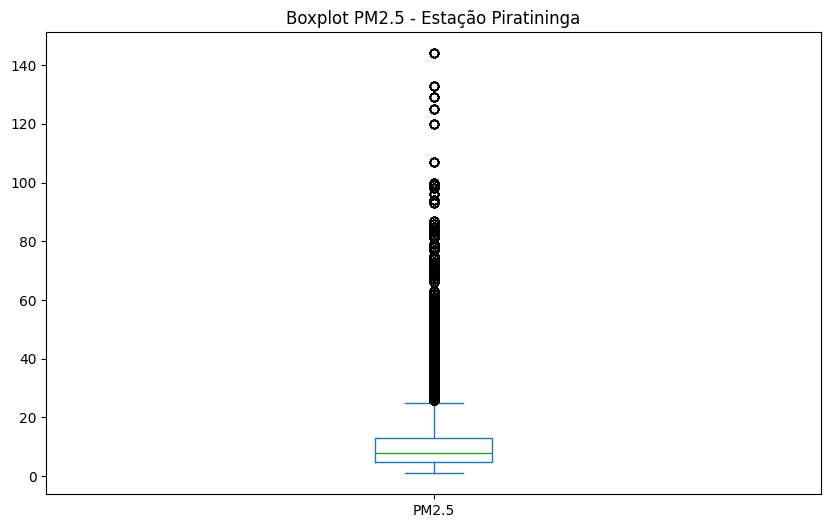

In [ ]:
# metodo do IQR para identificar outliers
import pandas as pd
import matplotlib.pyplot as plt

station_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]
for station_folder in reversed(station_folders):
    df_treated = pd.read_excel(f"tratados/{station_folder}/excel/{station_folder}_combined_treated.xlsx")
    print(f"Estação: {station_folder}")
    
    q1 = df_treated['PM2.5'].quantile(0.25)
    q3 = df_treated['PM2.5'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = df_treated[(df_treated['PM2.5'] < lower_bound) | (df_treated['PM2.5'] > upper_bound)]
    
    print(f"Quantidade de outliers: {len(outliers)}")
    print(outliers)
    print("-" * 50)
    
    plt.figure(figsize=(10, 6))
    df_treated['PM2.5'].plot(kind='box')
    plt.title(f"Boxplot PM2.5 - Estação {station_folder}")
    plt.show()

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

treated_folder = "tratados"
station_folders = [f for f in os.listdir(treated_folder) if os.path.isdir(os.path.join(treated_folder, f))]

for station_folder in station_folders:
    print(f"Análise descritiva para a estação: {station_folder}")
    
    treated_files = [f for f in os.listdir(os.path.join(treated_folder, station_folder)) if f.endswith(".csv")]
    
    for treated_file in treated_files:
        year = int(treated_file.split("_")[1])
        treated_file_path = os.path.join(treated_folder, station_folder, treated_file)
        df = pd.read_csv(treated_file_path, parse_dates=['Data e Hora'])
        
        if 'PM2.5' in df.columns:
            print(f"\nAno: {year}")
            
            # Estatísticas descritivas básicas
            pm25_stats = df['PM2.5'].describe()
            print("Estatísticas descritivas para PM2.5:")
            print(pm25_stats)
            
            # Verificar a distribuição dos valores de PM2.5 usando histograma
            plt.figure(figsize=(8, 6))
            plt.hist(df['PM2.5'], bins=20, edgecolor='black')
            plt.xlabel('Valor de PM2.5')
            plt.ylabel('Frequência')
            plt.title(f'Distribuição dos valores de PM2.5 - Estação {station_folder} - Ano {year}')
            plt.tight_layout()
            plt.show()
            
            # Verificar a distribuição dos valores de PM2.5 usando gráfico de densidade
            plt.figure(figsize=(8, 6))
            df['PM2.5'].plot(kind='kde')
            plt.xlabel('Valor de PM2.5')
            plt.ylabel('Densidade')
            plt.title(f'Distribuição dos valores de PM2.5 - Estação {station_folder} - Ano {year}')
            plt.tight_layout()
            plt.show()
            
            # Identificar possíveis outliers
            q1 = df['PM2.5'].quantile(0.25)
            q3 = df['PM2.5'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)
            outliers = df[(df['PM2.5'] < lower_bound) | (df['PM2.5'] > upper_bound)]
            print(f"\nPossíveis outliers para PM2.5 ({len(outliers)} ocorrências):")
            print(outliers['PM2.5'])
        
        else:
            print(f"\nAno: {year}")
            print("A coluna 'PM2.5' não está presente nos dados.")
    
    print("\n" + "-" * 50)


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# pega os nomes da estacoes
main_folder = "data"
station_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

#plota os graficos
for station_folder in reversed(station_folders):
    combined_data = pd.read_excel(f"tratados/{station_folder}/excel/{station_folder}_combined_treated.xlsx")
    # Especificando o formato correto da data
    combined_data['Data e Hora'] = pd.to_datetime(combined_data['Data e Hora'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.date
    combined_data = combined_data.set_index('Data e Hora')
    
    # Aumentando o tamanho do gráfico
    plt.figure(figsize=(10, 6))  
    
    combined_data['PM2.5'].plot()
    plt.title(f"{station_folder} PM2.5")
    plt.show()
